In [1]:
source("~/software/notebook_assist/functions.R")
source("~/software/notebook_assist/packages.R")

In [2]:
setwd("/projects/CARDIPS/analysis/epigenome_resource/")

In [3]:
theme_bw2 = theme_bw() +
    theme(
        axis.text = element_text(size = 12),
        strip.text = element_text(size = 12),
        axis.title = element_text(size = 12),
        legend.text = element_text(size = 12),
        legend.title = element_text(size = 12),
        legend.position = "top"
    )

In [4]:
### download ES-derived cardiomyocyte states 
#### wget https://personal.broadinstitute.org/cboix/epimap/ChromHMM/observed_aux_18_hg38/CALLS/BSS00171_18_CALLS_segments.bed.gz

### download iPSC-18a
#### wget https://personal.broadinstitute.org/cboix/epimap/ChromHMM/observed_aux_18_hg38/CALLS/BSS00737_18_CALLS_segments.bed.gz

In [5]:
basedir = "/home/tarthur/projects/Resource/"
cvpc_states = fread(paste0(basedir,"manuscript/input/figure2/BSS00171_18_CALLS_segments.bed.gz"),sep="\t",data.table=F)
ipsc_states = fread(paste0(basedir,"manuscript/input/figure2/BSS00737_18_CALLS_segments.bed.gz"),sep="\t",data.table=F)

In [9]:
# collapse_states = function(state_df) {
#     state_df$state [ state_df$V4 %in% c("EnhA1","EnhA2","EnhG1","EnhG2","EnhWk","EnhBiv")] = "Enhancer"
#     state_df$state [ state_df$V4 %in% c("Tx","TxWk")] = "Transcribed"
#     state_df$state [ state_df$V4 %in% c("Quies")] = "Quiescent"
#     state_df$state [ state_df$V4 %in% c("ReprPC","ReprPCWk","Het","ZNF/Rpts")] = "Repressed"
#     state_df$state [ state_df$V4 %in% c("TssA","TssBiv","TssFlnkU","TssFlnkD","TssFlnk")] = "Promoter"
#     state_df = state_df[ state_df$V1 %in% paste0("chr",1:22),]
#     state_df = state_df[ order(state_df$V1, state_df$V2, state_df$V3),]
#     return(state_df[, c(1:3,10)])
# }
ipsc_state_path = paste0(basedir,"notebooks/toGitHub/ipsc_states.bed")
cvpc_state_path = paste0(basedir,"notebooks/toGitHub/cvpc_states.bed")

# fwrite(collapse_states(cvpc_states),cvpc_state_path,sep="\t",row.names=F,col.names=F)
# fwrite(collapse_states(ipsc_states),ipsc_state_path,sep="\t",row.names=F,col.names=F)

In [8]:
filtered_qtl_path="analyses/tim/ld_modules/scripts/filtered_qtls_09042024.txt"
filtered_qtls = fread(filtered_qtl_path,sep="\t",data.table=F) 
filtered_qtls$datatype = ifelse(grepl("^E",filtered_qtls$element_id), "eQTL",
                               ifelse(grepl("atac",filtered_qtls$element_id), "caQTL","haQTL"))
table(filtered_qtls$datatype, filtered_qtls$conditional)
table(filtered_qtls$datatype)

       
        Conditional Primary
  caQTL        3013   30605
  eQTL         6354   19305
  haQTL         773   10396


caQTL  eQTL haQTL 
33618 25659 11169 

In [17]:
qtl_bed  = filtered_qtls

qtl_bed$chrom = paste0("chr",str_extract(qtl_bed$snp_id, "^[0-9]+"))
qtl_bed$end = as.numeric(gsub("_","",str_extract(qtl_bed$snp_id,"_[0-9]+")))
qtl_bed$start = qtl_bed$end - 1

### Read in aggregate QTL lead variants from Step 4 of pipeline
all_qtls = function(tissue) {
    qtls = rbindlist(list(fread(paste0("eqtls/",tissue,"/step_4/qtl_by_element/qtl.no_mhc.txt"),sep="\t",data.table=F)[,c("element_id","type","chrom","pos")],
                          fread(paste0("caqtls/",tissue,"/step_4/qtl_by_element/qtl.no_mhc.txt"),sep="\t",data.table=F)[,c("element_id","type","chrom","pos")],
                          fread(paste0("haqtls/",tissue,"/step_4/qtl_by_element/qtl.no_mhc.txt"),sep="\t",data.table=F)[,c("element_id","type","chrom","pos")])) %>%
                    filter(type == 0) %>% 
                    mutate(start = pos - 1, qtl_id = paste(element_id, type, sep="_")) %>% 
                           select(chrom, start, pos, qtl_id) %>% arrange(chrom, start, pos)

    new_qtls = qtl_bed [ qtl_bed$tissue == tissue,] 
    new_qtls$qtl_id = paste(new_qtls$element_id,new_qtls$type, sep="_")
    new_qtls2 = new_qtls %>% select(chrom, start,end, qtl_id)
    colnames(new_qtls2) = c("chrom","start","pos","qtl_id")
    qtls2 = qtls[ !qtls$qtl_id %in% new_qtls$qtl_id,]

    out = rbind(qtls2,new_qtls2)
    out$QTL = ifelse(out$qtl_id %in% new_qtls2$qtl_id , "TRUE","FALSE")
    out$Type = ifelse(grepl("^E",out$qtl_id), "eQTL",
                     ifelse(grepl("atac",out$qtl_id), "caQTL","haQTL"))

    return(unique(out %>% select(!qtl_id) %>% arrange(chrom,start,pos)))
    }
ipsc_qtls = all_qtls("iPSC")
cvpc_qtls = all_qtls("CVPC")


In [10]:
ipsc_qtl_path="~/projects/Resource/notebooks/toGitHub/ipsc_lead.bed"
cvpc_qtl_path="~/projects/Resource/notebooks/toGitHub/cvpc_lead.bed"

# fwrite(ipsc_qtls, ipsc_qtl_path,
#       sep="\t",row.names=F,quote=F,col.names=F)

# fwrite(cvpc_qtls, cvpc_qtl_path,
#       sep="\t",row.names=F,quote=F,col.names=F)

In [11]:
ipsc_int_path=paste0(basedir,"notebooks/toGitHub/ipsc_lead_state_annots.bed")

cvpc_int_path=paste0(basedir,"notebooks/toGitHub/cvpc_lead_state_annots.bed")

bedtools = "/frazer01/software/bedtools-2.25.0/bin/bedtools"

ipsc_command = paste(bedtools, "intersect", "-a", ipsc_state_path,
                     "-b", ipsc_qtl_path, "-wb",
                     ">", ipsc_int_path)

cvpc_command = paste(bedtools, "intersect", "-a", cvpc_state_path,
                     "-b", cvpc_qtl_path, "-wb",
                     ">", cvpc_int_path)

system(cvpc_command)
system(ipsc_command)

In [12]:
ipsc_annots = fread(ipsc_int_path, sep="\t",data.table=F)
cvpc_annots = fread(cvpc_int_path, sep="\t",data.table=F)
head(cvpc_annots)

,V1,V2,V3,V4,V5,V6,V7,V8,V9
,<chr>,<dbl>,<int>,<chr>,<chr>,<int>,<int>,<lgl>,<chr>
1,chr1,833842,833843,Quiescent,chr1,833842,833843,FALSE,caQTL
2,chr1,838666,838667,Quiescent,chr1,838666,838667,FALSE,caQTL
3,chr1,855084,855085,Transcribed,chr1,855084,855085,FALSE,caQTL
4,chr1,855084,855085,Transcribed,chr1,855084,855085,TRUE,haQTL
5,chr1,856472,856473,Transcribed,chr1,856472,856473,FALSE,haQTL
6,chr1,858951,858952,Quiescent,chr1,858951,858952,FALSE,eQTL


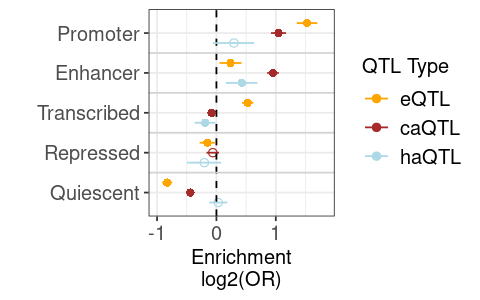

In [13]:
states=unique(ipsc_annots$V4)

chromstate_enrich = function( state, df, type) {
    tab = as.data.frame(table(df$V9, df$V4, df$V8))
    totest = tab[ tab$Var1 == type,]
    x11 = totest$Freq[ totest$Var2 == state     & totest$Var3 == "TRUE"]
    x12 = totest$Freq[ totest$Var2 == state     & totest$Var3 == "FALSE"]
    x21 = sum(totest$Freq[ totest$Var2 != state & totest$Var3 == "TRUE"])
    x22 = sum(totest$Freq[ totest$Var2 != state & totest$Var3 == "FALSE"])
    
    fish = fisher.test(matrix(c(x11,x12,x21,x22),nrow=2))
    out = data.frame(State = as.character(state), QTL = type,
                     `Odds Ratio` = fish$estimate, LowerCI = fish$conf.int[1],
                     UpperCI = fish$conf.int[2],Pvalue = fish$p.value)
    return(out)
}

ipsc_enrich = as.data.frame(rbindlist(list(rbindlist(lapply(states,chromstate_enrich, df = ipsc_annots, type ="eQTL")),
                            rbindlist(lapply(states,chromstate_enrich, df = ipsc_annots, type ="caQTL")),
                            rbindlist(lapply(states,chromstate_enrich, df = ipsc_annots, type ="haQTL")))))

cvpc_enrich = as.data.frame(rbindlist(list(rbindlist(lapply(states,chromstate_enrich, df = cvpc_annots, type ="eQTL")),
                            rbindlist(lapply(states,chromstate_enrich, df = cvpc_annots, type ="caQTL")),
                            rbindlist(lapply(states,chromstate_enrich, df = cvpc_annots, type ="haQTL")))))

fwrite(cvpc_enrich, "~/projects/Resource/notebooks/toGitHub/sourcedata/SOURCEDATA.FIGURE2E.txt",sep="\t",row.names=F,quote=F)
plot_enrichments = function(enrich_res) {
     enrich_res$`QTL Type` = factor(enrich_res$QTL , levels = c("haQTL","caQTL","eQTL"))
     enrich_res$State = factor(enrich_res$State, levels=rev(c("Promoter","Enhancer","Transcribed",
                                                                  "Repressed","Quiescent")))
    enrich_res$`log2(OR)` = log2(enrich_res$Odds.Ratio)
    enrich_res$log2Low = log2(enrich_res$LowerCI)
    enrich_res$log2Hi = log2(enrich_res$UpperCI)
    enrich_res$significant = ifelse(enrich_res$Pvalue > 0.05, "FALSE","TRUE")
    g= ggplot(enrich_res, aes(`log2(OR)`, State, color = `QTL Type`, group=`QTL Type`, shape=significant)) + theme_bw() +
            xlim(c(-1,1.85))+ ylab("") + xlab("Enrichment\nlog2(OR)") +
            theme_bw2 + theme(legend.position = "right") +
            geom_point(na.rm=TRUE, position=position_dodge(width=0.75),size=2) +
            geom_vline(xintercept = 0,lty =2 ) +
            geom_linerange(aes(x=`log2(OR)`, xmin=log2Low, xmax=log2Hi), 
                  na.rm=TRUE, position=position_dodge(width=0.75)) +
            scale_color_manual(values = rev(c("orange","brown","lightBlue"))) + 
            geom_hline(yintercept = 1.5, color = "lightgrey") +
            geom_hline(yintercept = 2.5, color = "lightgrey") +
            geom_hline(yintercept = 3.5, color = "lightgrey") +
            geom_hline(yintercept = 4.5, color = "lightgrey") +
            scale_shape_manual(values = c(1, 16), guide = "none") + guides(color = guide_legend(reverse = TRUE))
    return(g)
}

psize(2.5,4)
ipsc_chromplot = plot_enrichments(ipsc_enrich)
cvpc_chromplot = plot_enrichments(cvpc_enrich)
ipsc_chromplot


In [33]:
cvpc_enrich

State,QTL,Odds.Ratio,LowerCI,UpperCI,Pvalue
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
Quiescent,eQTL,0.5561576,0.5189447,0.5960909,4.210950e-62
Repressed,eQTL,0.8100738,0.7076174,0.9253564,1.621395e-03
Transcribed,eQTL,1.7549483,1.6146630,1.9067308,1.462638e-39
Enhancer,eQTL,1.3173056,1.1214698,1.5440026,7.451132e-04
Promoter,eQTL,3.0653990,2.6251673,3.5802892,1.142671e-45
Quiescent,caQTL,0.7933926,0.7608903,0.8274289,7.290603e-27
Repressed,caQTL,1.0061077,0.9287250,1.0886207,8.722228e-01
Transcribed,caQTL,1.0562676,0.9994616,1.1157285,5.040853e-02
Enhancer,caQTL,1.7393309,1.6114351,1.8755733,9.324335e-42


In [34]:
fwrite(cvpc_enrich,"~/projects/Resource/notebooks/toGitHub/sourcedata/figure2/figure2e.txt",
       sep="\t",row.names=F,quote=F)

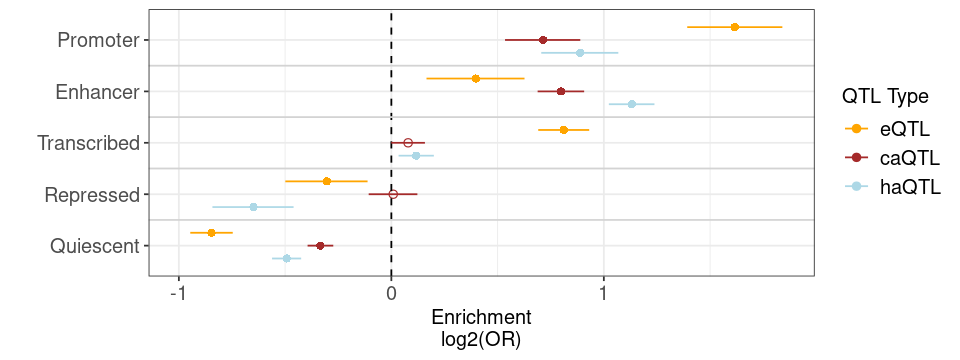

In [37]:
cvpc_chromplot2 = cvpc_chromplot + theme(legend.position = "right") + 
                    guides(col = guide_legend(nrow = 3, theme = theme(legend.byrow = TRUE), reverse = TRUE))
cvpc_chromplot2

In [39]:
png("~/projects/Resource/notebooks/toGitHub/supplementalfigures/figure_s8_v2.png",
    res=300, units="in",height=2.5,width=4)
ipsc_chromplot2 = ipsc_chromplot + theme(legend.position = "right") + 
                    guides(col = guide_legend(nrow = 3, theme = theme(legend.byrow = TRUE),reverse = TRUE))
ipsc_chromplot2
dev.off()

png 
  2

In [57]:
psize(4,8)
png("~/projects/Resource/notebooks/toGitHub/supplementalfigures/cs_response.png",
    res=150, units="in",height=3,width=8)
plot_grid(ipsc_chromplot2  + ggtitle("iPSC"),
          cvpc_chromplot2 + ggtitle("CVPC"))
dev.off()

png 
  2

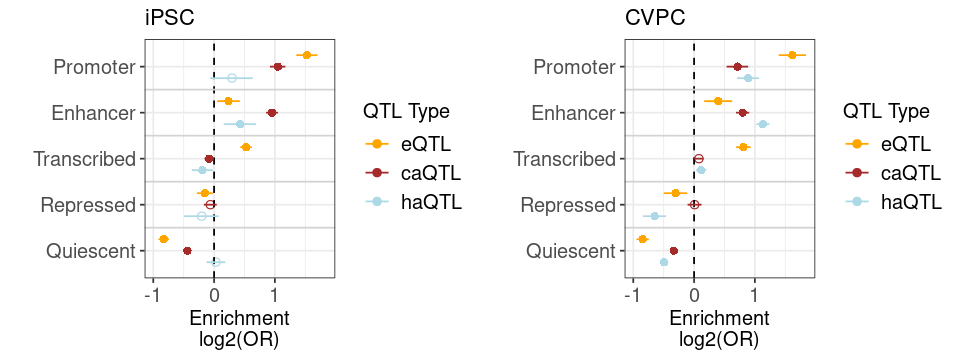

In [38]:
psize(3,8)
m = cvpc_chromplot2 + ggtitle("CVPC")
n = ipsc_chromplot2 + ggtitle("iPSC")
plot_grid(n,m,nrow =1)